In [ ]:
from IPython.display import Image, display

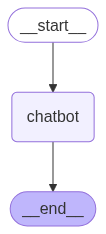

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Annotated

# load model from ollama
llm = init_chat_model(
    "ollama:gemma3:12b",
)

# set up graph
class State(TypedDict):
    messages: Annotated[list, add_messages]

# define graph builder for the state
graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()


try:
    get_graph = graph.get_graph()
    mermaid = get_graph.draw_mermaid_png()
    image = Image(mermaid)
    display(image)
except Exception as e:
    print(f"Error generating graph: {e}")

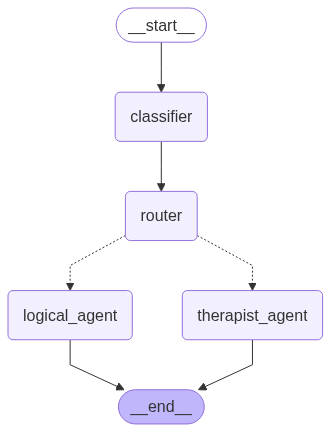

In [3]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Annotated
from typing import Literal

# load model from ollama
llm = init_chat_model(
    "ollama:gemma3:4b",
    n_ctx=8192,  # Set context length to 8192 tokens
)

# define strucutred message format 
class MessageClasifier(BaseModel):
    message_type: Literal["emotional", "logical"] = Field(
        ...,
        description="Classify if the message requires an emotional (therapist) or logical response.",
    )

# set up graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    message_types: str | None


def classify_message(state: State):
    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(MessageClasifier)

    result = classifier_llm.invoke(
        [
            {
            "role": "system",
            "content": """Classify the user message as either:
            - 'emotional': if it asks for emotional support, therapy, deals with feelings, or personal problems
            - 'logical': if it asks for facts, information, logical analysis, or practical solutions
            """,
            },
            {
                "role": "user",
                "content": last_message.content,
            },
        ]
    )

    print(f"Classifier result: {result.message_type}")

    return {"message_types": result.message_type}

def router(state: State) :
    message_type = state.get("message_type", "logical") # Default to logical if not set
    if message_type == "emotional":
        return {"next": "therapist_agent"}
    else:
        return {"next": "logical_agent"}

def therapist_agent(state: State) :
    last_message = state["messages"][-1]
    messages = [
        {
            "role": "system",
            "content": "Do not use markdown formatting in your responses."
        },
        {
            "role": "system",
            "content": """You are a compassionate therapist. Focus on the emotional aspects of the user's message.
                        Show empathy, validate their feelings, and help them process their emotions.
                        Ask thoughtful questions to help them explore their feelings more deeply.
                        Avoid giving logical solutions unless explicitly asked."""
        },
        {
            "role": "user",
            "content": last_message.content,
        }
    ]

    reply = llm.invoke(messages)
    return {
        "messages": [{"role": "assistant", "content": reply.content}],
        "message_types": None
    }

def logical_agent(state: State) :
    last_message = state["messages"][-1]
    messages = [ 
        {
            "role": "system",
            "content": "Do not use markdown formatting in your responses."
        },
        {
            "role": "system",
            "content": """You are a purely logical assistant. Focus only on facts and information.
            Provide clear, concise answers based on logic and evidence.
            Do not address emotions or provide emotional support.
            Be direct and straightforward in your responses."""
        },
        {
            "role": "user",
            "content": last_message.content,
        }
    ]

    reply = llm.invoke(messages)
    return {
        "messages": [{"role": "assistant", "content": reply.content}],
        "message_types": None
    }

# define graph builder for the state
graph_builder = StateGraph(State)
graph_builder.add_node("classifier", classify_message)
graph_builder.add_node("router", router)
graph_builder.add_node("therapist_agent", therapist_agent)
graph_builder.add_node("logical_agent", logical_agent)

graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")
graph_builder.add_conditional_edges(
    source="router",
    path=lambda state: state.get("next"),
    path_map={"therapist_agent": "therapist_agent", "logical_agent": "logical_agent"}
)

graph_builder.add_edge("therapist_agent", END)
graph_builder.add_edge("logical_agent", END)

graph = graph_builder.compile()

try:
    get_graph = graph.get_graph()
    mermaid = get_graph.draw_mermaid_png()
    image = Image(mermaid)
    display(image)
except Exception as e:
    print(f"Error generating graph: {e}")